# Use a ball and spring model for a jump-rope 

The goal of this notebook is to accurately model a spring being rotated like a jump rope. It is possible to also find modes above the fundamental however these were not investigated. The First step is to create functions to model the initial conditions of the string, the forces on each ball, and the motion of the ball over time.

## Import the necessary packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ode
from scipy.optimize import curve_fit
from vpython import * #yes, I know I'm not supposed to do this
from scipy.linalg import eigh
from tqdm import tqdm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Define the essential functions:

#### - Model for the string over time

In [2]:
def run_string(Npoints,xi,yi,zi,xveli,yveli,zveli):    
    #lists
    ta = []
    xpos = []
    ypos = []
    zpos = []
    xvel = []
    yvel = []
    zvel = []
    
    t = 0
    
    #append initial values
    ta.append(t)
    xpos.append(xi)
    ypos.append(yi)
    zpos.append(zi)
    xvel.append(xveli)
    yvel.append(yveli)
    zvel.append(zveli)

    #vector
    y0 = np.array([xi,yi,zi,xveli,yveli,zveli])
    
    for i in tqdm(range(0,Npoints)):
        #integrate
        y1 = ode.RK4(model_string, y0, t, h) #update y[n]
                
        for n in range(N):
            y0[0][n] = y1[0][n]
        for n in range(N):
            y0[1][n] = y1[1][n]
        for n in range(N):
            y0[2][n] = y1[2][n]
        for n in range(N):
            y0[3][n] = y1[3][n]
        for n in range(N):
            y0[4][n] = y1[4][n]
        for n in range(N):
            y0[5][n] = y1[5][n]
        t = t + h #update clock
        
        #append updated values for each time step
        ta.append(t)
        xpos.append(y1[0])
        ypos.append(y1[1])
        zpos.append(y1[2])
        xvel.append(y1[3])
        yvel.append(y1[4])
        zvel.append(y1[5])                    
    return np.array(ta), np.array(xpos), np.array(ypos), np.array(zpos), np.array(xvel), np.array(yvel), np.array(zvel)

#### - Create the numerical ode solution

In [3]:
def model_string(y0, t): # y=[u,udot]; function returns derivative    
    x = y0[0] #array of x-positions
    y = y0[1] #array of y-positions
    z = y0[2] #array of x-positions
    u = np.sqrt(np.square(x)+np.square(y)+np.square(z))
    xdot = y0[3] #array of x-velocities
    ydot = y0[4] #array of y-veloctities
    zdot = y0[5] #array of z-velocities
    xddot = np.zeros(N)
    yddot = np.zeros(N)
    zddot = np.zeros(N)

    for i in range(0,N):
        if i==0:
            leftpos=np.asarray([0,0,0])#left wall
            centerpos=np.asarray([x[i],y[i],z[i]])
            rightpos=np.asarray([x[i+1],y[i+1],z[i+1]])
            
            Forces=force_model(leftpos,rightpos,centerpos)
            xddot[i]=Forces[0]
            yddot[i]=Forces[1]
            zddot[i]=Forces[2]
            
        elif i==N-1:
            leftpos=np.asarray([x[i-1],y[i-1],z[i-1]])
            centerpos=np.asarray([x[i],y[i],z[i]])
            rightpos=np.asarray([L,0,0])#right wall
            
            Forces=force_model(leftpos,rightpos,centerpos)
            xddot[i]=Forces[0]
            yddot[i]=Forces[1]
            zddot[i]=Forces[2]
            
        else:
            leftpos=np.asarray([x[i-1],y[i-1],z[i-1]])
            centerpos=np.asarray([x[i],y[i],z[i]])
            rightpos=np.asarray([x[i+1],y[i+1],z[i+1]])
            
            Forces=force_model(leftpos,rightpos,centerpos)
            xddot[i]=Forces[0]
            yddot[i]=Forces[1]
            zddot[i]=Forces[2]
            
    
    return np.array([xdot,ydot,zdot,xddot,yddot,zddot])

#### - Model the force on each atom

In [4]:
def force_model(left,right,center):    
    #setup and calculate the force from the left side
    left_rel=(center-left) #vector from the left atom to atom i
    left_d=np.sqrt(left_rel[0]**2+left_rel[1]**2+left_rel[2]**2) #distance from atom i to the atom on the left
    left_hat=left_rel/left_d #unit vector from the left atom to atom i
    Fleft=-k*(left_d-L0)*left_hat #force calculation of the left side

        
    #setup and calculate the force from the rigth side
    right_rel=center-right #vector from right to atom i
    right_d=np.sqrt(right_rel[0]**2+right_rel[1]**2+right_rel[2]**2) #distance from right to atom i
    right_hat=right_rel/right_d #unit vector from right to atom i
    Fright=-k*(right_d-L0)*right_hat #force calculation of the right side
    
    #sum the net force
    Fnet=Fleft+Fright
    return Fnet

#### - Model a sinusoidal wave

In [5]:
def sinusoidal(x,ang,A):
    return A*np.sin(ang*x)

## Define useful global variables:

In [6]:
global N, k, m, h, L, L0

N = 25
k = 50
m = 1
t_total = 105
L=10
h = 1e-3
Npoints=int(t_total/h)
mode = 1
L0 = L/(N+1)

first_x=L0
last_x=L-L0

ang=2*np.pi*mode/(2*L)

## Model the jump rope using the momentum principle:

By setting the initial positions of each atom to the maximum displacement of a sinusoidal wave we can say that the perpendicular force that keeps each atom in a circular orbit should be equal to the net force in the y-direction at their initial positions.
$$ F_{\perp}=F_{net_y}=\frac{Mv^2}{R}$$
Solving for velocity returns:
$$v_i=\sqrt{\frac{F_{net_y}R}{M}}$$

In [ ]:
xposi= np.linspace(first_x,last_x,N)
yposi= sinusoidal(xposi,ang,1)
zposi= np.zeros(N)
    

xvels= np.zeros(N)
yvels= np.zeros(N)

#find the perpendicular force then calculate the initial velocity
zvel0= np.zeros(N)

start_array = np.array([xposi,yposi,zposi,xvels,yvels,zvel0])
initial_cond= model_string(start_array,0)

zvels= np.sqrt(-yposi*initial_cond[4,:])

print(zvels)

In [ ]:
ta, xpos, ypos, zpos, xvel, yvel, zvel=run_string(Npoints,xposi,yposi,zposi,xvels,yvels,zvels)

## Plot the path of the middle atom
The center atom should follow a circular orbit if the model is physically accurate

In [ ]:
%matplotlib notebook
plt.figure(figsize=(6,6))
plt.plot(zpos[:,int(N/2)],ypos[:,int(N/2)],'b-')

## Visually check with VPython

In [ ]:
Balls= []

scene=canvas()
scene.width = 800
scene.height = 450
scene.background = color.white
scene.center = vec(xposi[int(N/2)],0,0)


for i in range(N):
    Balls.append(sphere(pos=vec(xpos[0,i], ypos[0,i], zpos[0,i]), radius=L/(2*N), color=color.red))

for n in range(len(ta)):
    rate(500)
    for i in range(N):
        Balls[i].pos=vec(xpos[n,i], ypos[n,i], zpos[n,i])
    

## Maybe that was the wrong approach to find velocity?

### Try a distance over time calculation:

$$ v_i=\frac{distance}{time}=\frac{circumference}{period}=\frac{2\pi R}{T}$$

Let's visually look for a period of the middle atom. All atoms should have the same period but the middle atom will have the most displacement.

In [ ]:
xposi= np.linspace(first_x,last_x,N)
yposi= sinusoidal(xposi,ang,1)
zposi= np.zeros(N)
    

xvels= np.zeros(N)
yvels= np.zeros(N)
zvel0= np.zeros(N)

In [ ]:
ta, xpos, ypos, zpos, xvel, yvel, zvel=run_string(Npoints,xposi,yposi,zposi,xvels,yvels,zvel0)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(6,6))
plt.plot(ta,ypos[:,int(N/2)],'b-')

## Guess and check around the observed period until a circular orbit is acheived

In [7]:
xposi= np.linspace(first_x,last_x,N)
yposi= sinusoidal(xposi,ang,1)
zposi= np.zeros(N)
    
T = 47.6139782578

xvels= np.zeros(N)
yvels= np.zeros(N)
zvels=2*np.pi*yposi/T

print(zvels)

[0.01590613 0.03158032 0.04679399 0.06132531 0.07496236 0.08750629
 0.09877418 0.10860172 0.11684561 0.12338562 0.12812639 0.1309988
 0.13196094 0.1309988  0.12812639 0.12338562 0.11684561 0.10860172
 0.09877418 0.08750629 0.07496236 0.06132531 0.04679399 0.03158032
 0.01590613]


In [8]:
ta, xpos, ypos, zpos, xvel, yvel, zvel=run_string(Npoints,xposi,yposi,zposi,xvels,yvels,zvels)

100%|█████████████████████████████████████████████████████████████████████████| 105000/105000 [03:28<00:00, 502.99it/s]


<IPython.core.display.Javascript object>


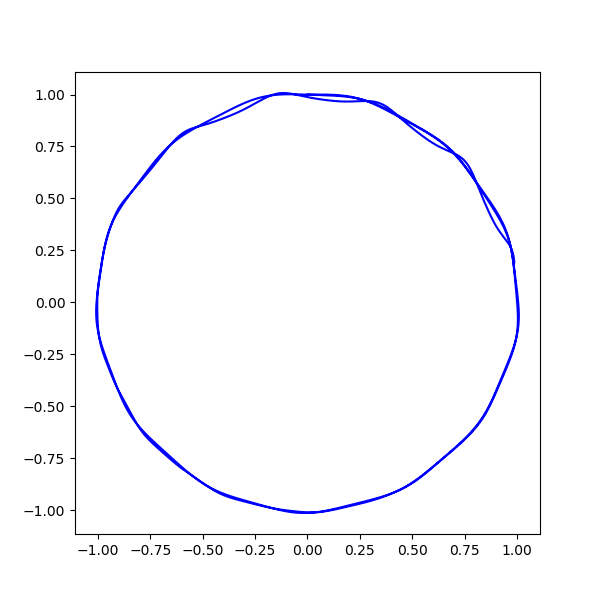

In [9]:
%matplotlib notebook
plt.figure(figsize=(6,6))
plt.plot(zpos[:,int(N/2)],ypos[:,int(N/2)],'b-')

In [10]:
Balls= []

scene=canvas()
scene.width = 800
scene.height = 450
scene.background = color.white
scene.center = vec(xposi[int(N/2)],0,0)


for i in range(N):
    Balls.append(sphere(pos=vec(xpos[0,i], ypos[0,i], zpos[0,i]), radius=L/(2*N), color=color.red))

for n in range(len(ta)):
    rate(500)
    for i in range(N):
        Balls[i].pos=vec(xpos[n,i], ypos[n,i], zpos[n,i])
    

<IPython.core.display.Javascript object>

## Conclusions

It is clear in both the z vs. y plot and the VPython animation that the initial velocities of each atom should not be proportional to starting position and net force. I am unsure as to the significance of the period of the string but it would seem like the period is related to spring stifness and length of the string due to the experimental behavior of this model.